In [1]:
# ! pip install --upgrade ultralytics
# !pip install --upgrade -U ray[tune]

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

! wandb disabled

/bin/bash: line 1: wandb: command not found


In [3]:
class CFG:
    DEBUG = True # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['door', 'cabinetDoor', 'refrigeratorDoor',
               'window', 'chair', 'table', 'cabinet', 'couch',
               'openedDoor', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = "/home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/"
    OUTPUT_DIR = (
        "/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/"
    )

Create ```data.yaml``` file properly formatted to be used by Yolo

In [4]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/test
train: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train
val: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/valid



Visualize one image

In [6]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (683, 1024, 3) 



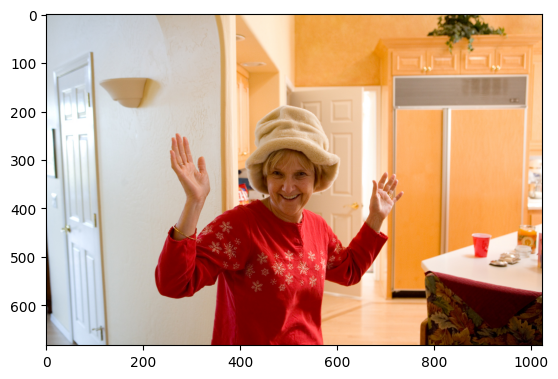

In [7]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/000c052bb4b882c4.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

Visualize many images

In [8]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

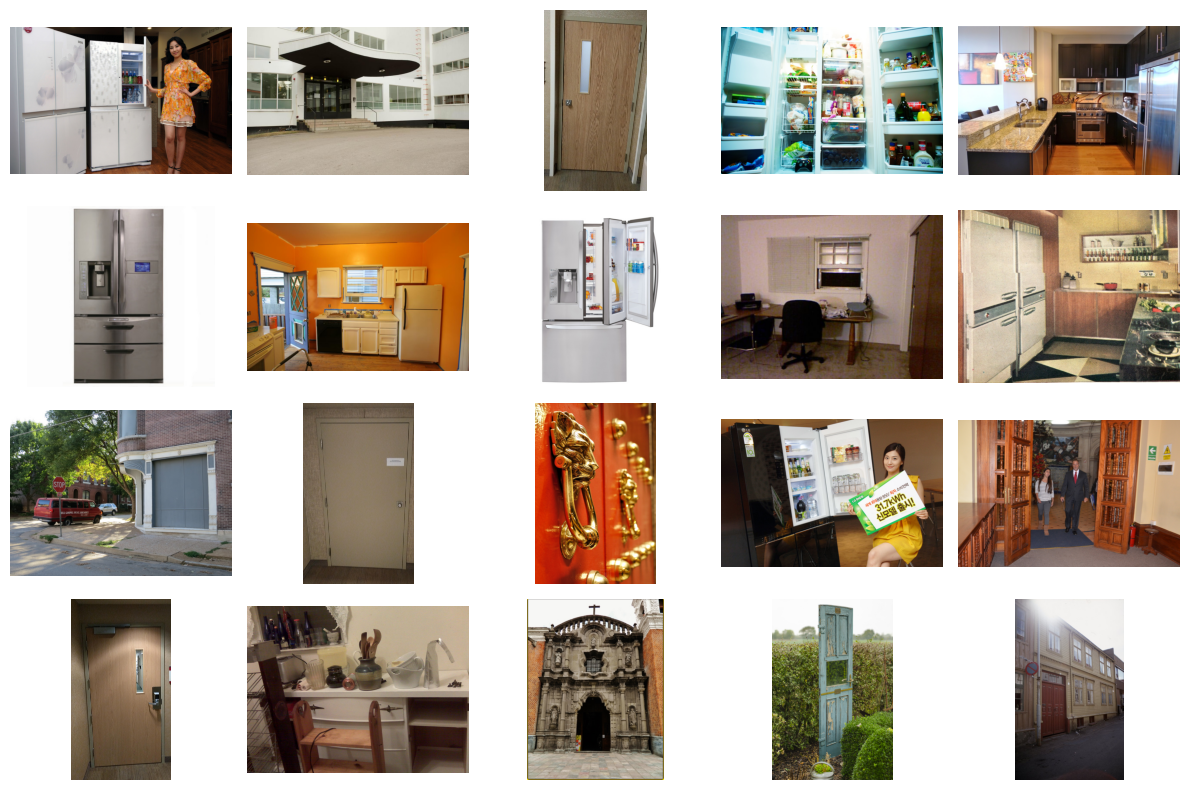

In [9]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

Image properties

In [10]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [11]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 683, 'channels': 3, 'dtype': dtype('uint8')}

Dataset statistics

In [12]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)


,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


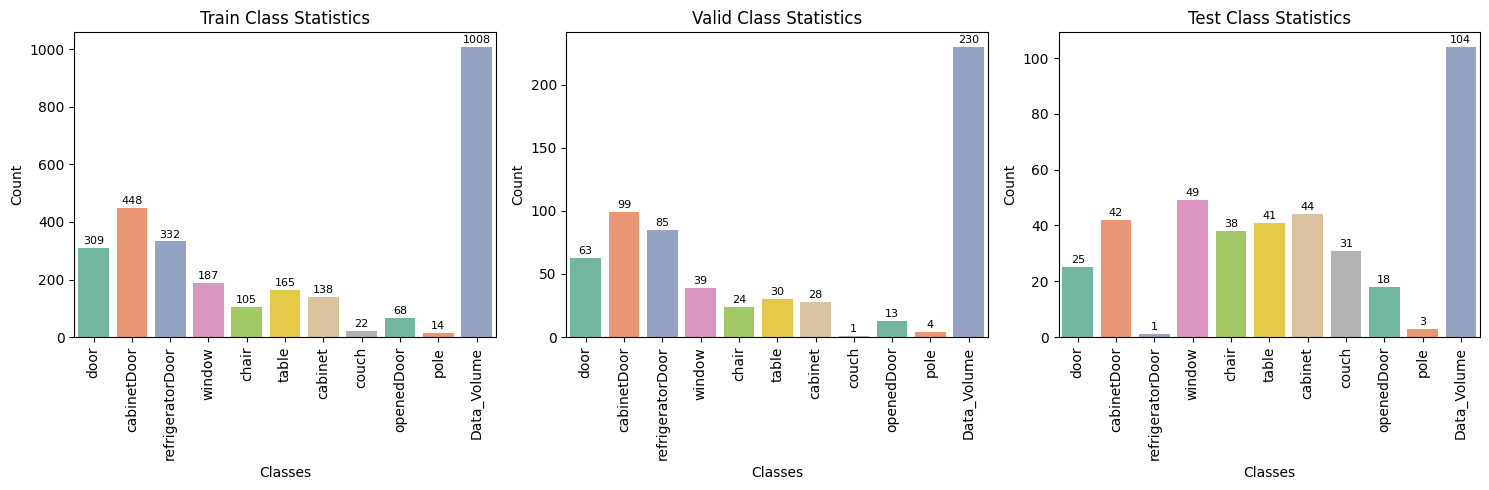

In [13]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

Base Model Inference

Checking the power of the pretrained model inference on the CSS dataset

In [14]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:10<00:00, 11.2MB/s] 



WARNING ⚠️ imgsz=[683, 1024] must be multiple of max stride 32, updating to [704, 1024]
image 1/1 /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/images/000c052bb4b882c4.jpg: 704x1024 1 person, 73.6ms
Speed: 2.3ms preprocess, 73.6ms inference, 94.8ms postprocess per image at shape (1, 3, 704, 1024)
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict
3 labels saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (683, 1024, 3) 



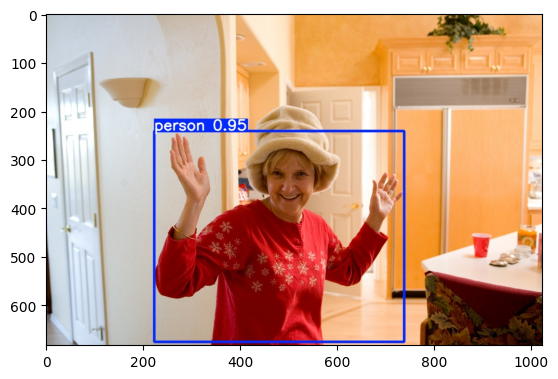

In [15]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(
    f"/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/predict/{example_image_inference_output}"
)

Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [16]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  3
Batch:  16


In [17]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

**IMPORTANT**<br>
Modify `/home/user/.config/Ultralytics/settings.yaml` file so that there is no errors loading the data


In [18]:
%%time
import torch
torch.cuda.empty_cache()
### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    # imgsz = (img_properties['height'], img_properties['width']),
    imgsz=(320, 320),
    epochs = CFG.EPOCHS,
    # batch = CFG.BATCH_SIZE,
    batch = 16,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0],
#     device = None, # CPU run
    verbose = False,
)

New https://pypi.org/project/ultralytics/8.3.126 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.124 🚀 Python-3.12.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7908MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/data.yaml, epochs=3, time=None, patience=20, batch=16, imgsz=(320, 320), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_3_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.05, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=Tru

100%|██████████| 5.35M/5.35M [00:00<00:00, 10.7MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=320'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7510.9±1877.7 MB/s, size: 255.9 KB)


train: Scanning /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/labels... 51 images, 4 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<00:00, 1325.35it/s]

train: New cache created: /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1071.1±782.3 MB/s, size: 339.8 KB)


val: Scanning /home/nickolasz/Projects/DataSets/GoIT/Indoor_Objects_Detection/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_3_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_3_epochs
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3       5.1G      2.489      4.761      2.059         19        320: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]

                   all        230       1289    0.00185      0.251    0.00334    0.00195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      5.11G      2.471       4.72      2.165          9        320: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]

                   all        230       1289    0.00173      0.248    0.00336     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      5.55G      2.392      4.459      1.968         13        320: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

                   all        230       1289      0.801     0.0778     0.0766     0.0464



3 epochs completed in 0.003 hours.
Optimizer stripped from /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_3_epochs/weights/last.pt, 117.2MB
Optimizer stripped from /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_3_epochs/weights/best.pt, 117.2MB

Validating /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_3_epochs/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.12.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7908MiB)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]


                   all        230       1289      0.802     0.0769     0.0768     0.0465
Speed: 0.1ms preprocess, 5.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs/detect/yolov9e_ppe_css_3_epochs
CPU times: user 15.4 s, sys: 6.51 s, total: 21.9 s
Wall time: 22.4 s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea957830560>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

[Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv9 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [19]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.124 🚀 Python-3.12.3 torch-2.7.0+cu126 CPU (Intel Core(TM) i9-14900HX)


AssertionError: ERROR ❌️ argument 'fraction' is not supported for format='onnx'

Train results

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

[]

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,262.915,1.30013,1.84316,1.55112,0.44940,0.47021,0.43807,0.20111,1.95197,2.16340,2.08141,0.000238,0.000238,0.000238
1,1,261.126,1.30013,1.84316,1.55112,0.44940,0.47021,0.43807,0.20111,1.95197,2.16340,2.08141,0.000238,0.000238,0.000238
2,2,521.486,1.34179,1.81126,1.58606,0.52246,0.44729,0.45954,0.19847,2.00323,2.16107,2.17956,0.000469,0.000469,0.000469
3,3,769.313,1.30441,1.76970,1.55585,0.70012,0.39114,0.47494,0.20335,2.04754,1.92020,2.19292,0.000693,0.000693,0.000693
4,4,1008.530,1.27142,1.66751,1.52701,0.63988,0.49309,0.51644,0.22166,1.96854,1.99778,2.12781,0.000684,0.000684,0.000684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,56,1428.540,0.97878,0.68688,1.05900,0.37817,0.37951,0.37060,0.22083,1.35062,1.18126,1.36363,0.000159,0.000159,0.000159
72,57,1454.020,0.96673,0.69103,1.05969,0.51214,0.34881,0.38960,0.22728,1.39218,1.23229,1.38643,0.000149,0.000149,0.000149
73,58,1479.800,0.95458,0.66833,1.05033,0.44424,0.39950,0.40239,0.23171,1.38962,1.20927,1.38692,0.000138,0.000138,0.000138
74,59,1505.390,0.95519,0.65819,1.04635,0.44503,0.56593,0.46088,0.27135,1.34417,1.16870,1.35065,0.000128,0.000128,0.000128


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.95321 , on epoch:  76 


Best Validation Box loss:  1.32935 , on epoch:  71 


Best Training Cls loss:  0.64908 , on epoch:  76 


Best Validation Cls loss:  1.14627 , on epoch:  66 


Best Training DFL loss:  1.04476 , on epoch:  76 


Best Validation DFL loss:  1.32676 , on epoch:  51 



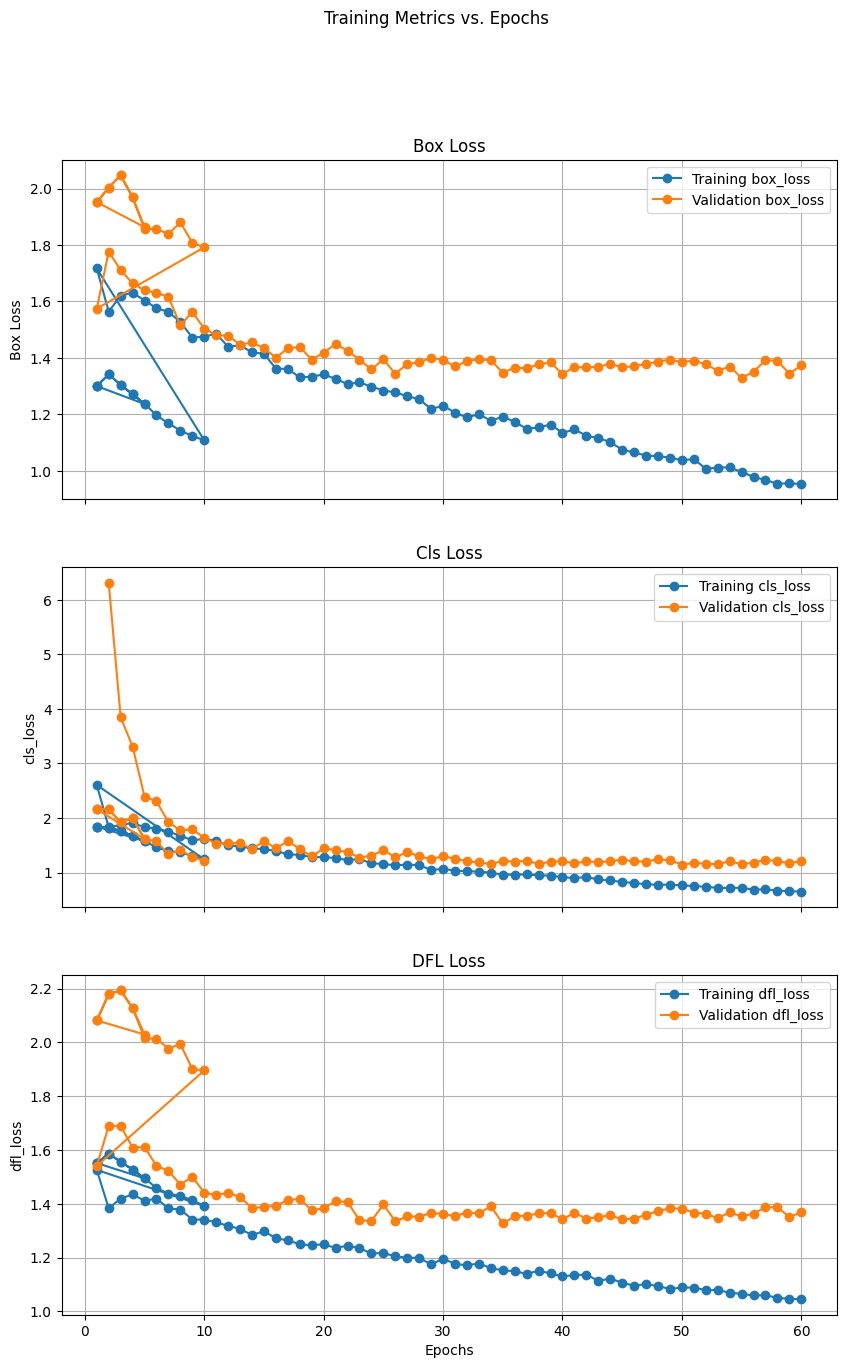

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

Validation results

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs//detect/yolov9e_ppe_css_70_epochs/val_batch1_labels.jpg


/home/nickolasz/Projects/GoIT/DEEP-LEARNING-FOR-COMPUTER-VISION-AND-NLP/runs//detect/yolov9e_ppe_css_70_epochs/val_batch1_labels.jpg


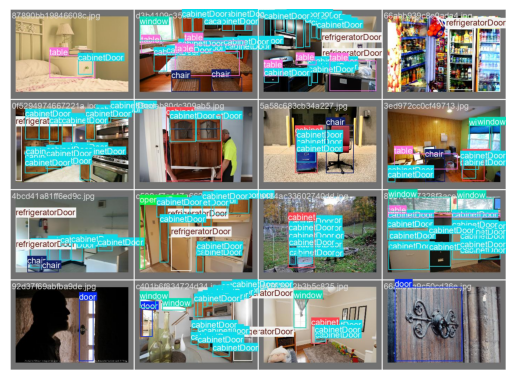

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)